In [1]:
# Load libraries
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from fancyimpute import KNN
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import joblib 
%matplotlib inline

In [2]:
# For maximizing Cell width of Jupyter Notebook Cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# For Not Displaying warnings
import warnings
warnings.filterwarnings('ignore')

#### Problem Statement​ -
You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected the historical data from your pilot project and now have a requirement to apply analytics forfare prediction. You need to design a system that predicts the fare amount for a cab ride in the city.

# Data is available on https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data

In [5]:
# Load data
car_df_train = pd.read_csv(r"D:\projects\Self Project\New York City Taxi Fare Prediction\dataset\train_cab.csv", na_values={'fare_amount':'430-'})
car_df_test = pd.read_csv("D:\\projects\\Self Project\\New York City Taxi Fare Prediction\\dataset\\test.csv")

In [6]:
# Display Shape of dataframe (Rows, Columns)
car_df_train.shape , car_df_test.shape

((16067, 7), (9914, 6))

In [7]:
# Display Top 5 rows of dataframe
car_df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [8]:
# Check Datatypes of all the columns present in the dataset
car_df_train.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

The details of data attributes in the dataset are as follows:
-  pickup_datetime - timestamp value indicating when the cab ride started.
-  pickup_longitude - float for longitude coordinate of where the cab ride started.
-  pickup_latitude - float for latitude coordinate of where the cab ride started.
-  dropoff_longitude - float for longitude coordinate of where the cab ride ended.
-  dropoff_latitude - float for latitude coordinate of where the cab ride ended.
-  passenger_count - an integer indicating the number of passengers in the cab ride.

In [9]:
# Check Number of Unique values present in each variable
car_df_train.nunique()

fare_amount            467
pickup_datetime      16021
pickup_longitude     13789
pickup_latitude      14241
dropoff_longitude    13887
dropoff_latitude     14263
passenger_count         27
dtype: int64

In [10]:
# Describe Columns of Dataframe and check mean, std, quartiles, min-max for all variables
car_df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963642,40.768014,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


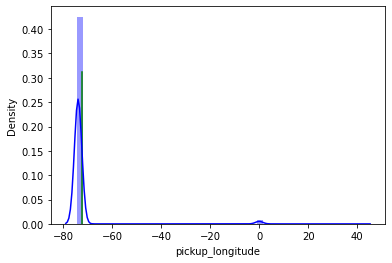

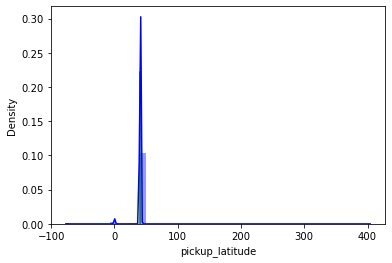

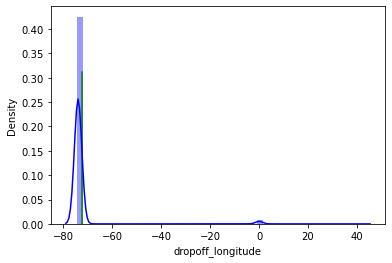

In [11]:
############################################### Data Visualization ##########################################################
continous_column_names = ['pickup_longitude','pickup_latitude','dropoff_longitude']
# Histogram - Distribution plot for all continous variables
for i,col in enumerate(continous_column_names):
    #fig, ax = plt.subplots()
    #fig.set_size_inches(11.7, 8.27)
    plt.figure(i)
    plt.axvline(car_df_train[col].mean(), 0,0.7, color = 'g')
    sns.distplot(car_df_train[col], color = 'b')

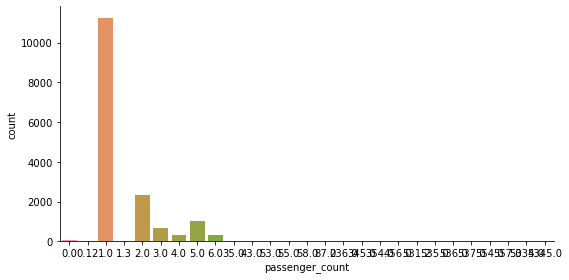

In [12]:
# factorplot for all categorical variables
category_column_names = ['passenger_count']
for i in category_column_names:
    sns.factorplot(data=car_df_train,x=i,kind='count',size=4,aspect=2)

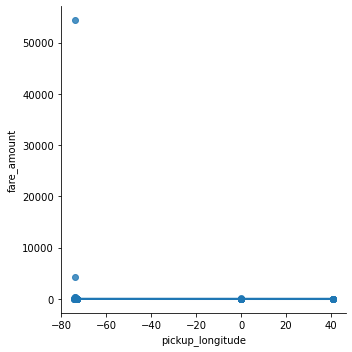

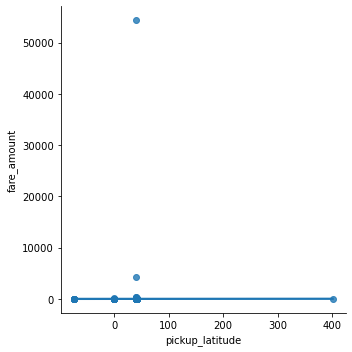

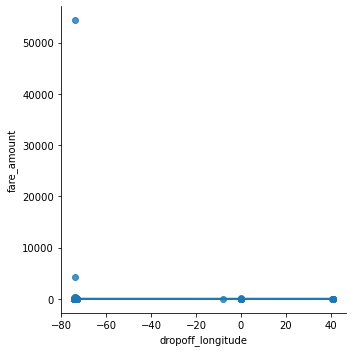

In [13]:
# Bivariate Analysis of all continous variables with Target Variable.
for i,col in enumerate(continous_column_names):
    sns.lmplot(x=col, y="fare_amount", data=car_df_train)   

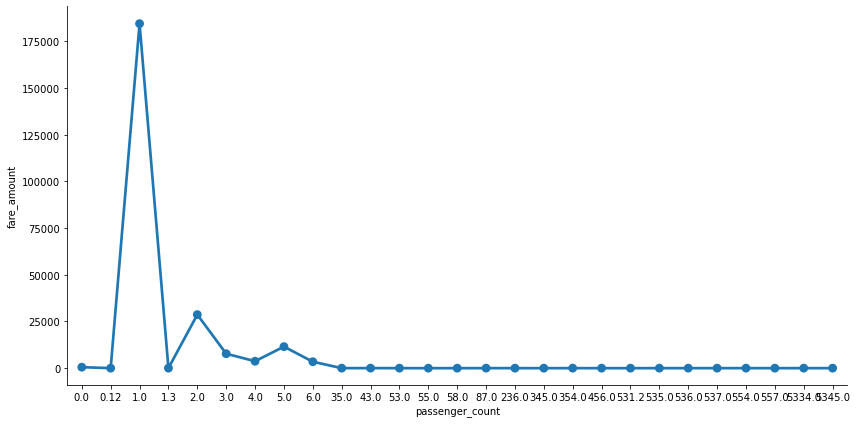

In [14]:
# Bivariate Analysis of all categorical variables with Target Variable.
for col in category_column_names:
    df_cat = pd.DataFrame(car_df_train.groupby([col], as_index=False).sum())
    sns.catplot(x=col, y="fare_amount", data=df_cat.reset_index(), kind="point", height=6, aspect=2)

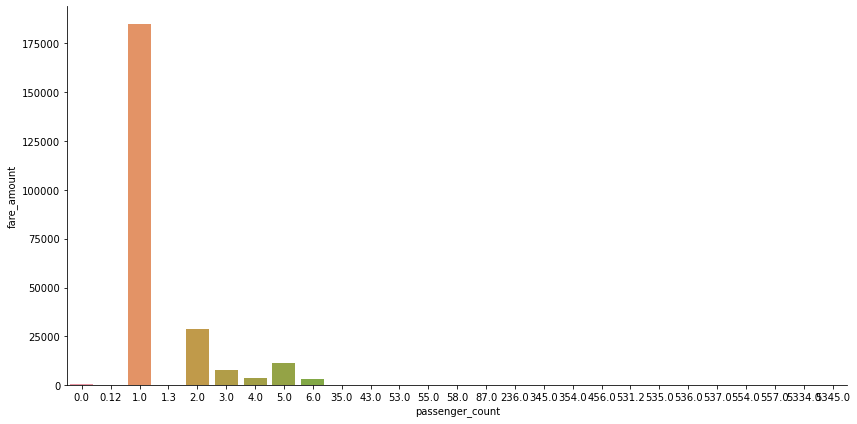

In [15]:
for col in category_column_names:
    df_cat = pd.DataFrame(car_df_train.groupby([col], as_index=False).sum())
    sns.catplot(x=col, y="fare_amount", data=df_cat.reset_index(), kind="bar", height=6, aspect=2)

In [16]:
############################################# Exploratory Data Analysis ####################################################

#Converting to appropriate datatypes

# Converting fare_amount to float and pickup_datetime to datetime format for both train and test dataset

complete_data = [car_df_train, car_df_test]
for data in complete_data:
    data['pickup_datetime']  = pd.to_datetime(data['pickup_datetime'],errors='coerce')

car_df_train['fare_amount'] =  car_df_train['fare_amount'].astype('float')


In [17]:
### Checking datatypes of train data
car_df_train.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [18]:
### Checking datatypes of test data
car_df_test.dtypes

pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [19]:
# Eliminating values from variables which do not follow standards depending on 
    # basic understanding of the problem statement

# 1. Passenger count of any vehicle (i.e a Car can reach upto max 7, hence any 
    # number of passengers more than 7 is an outlier and should be removed)
for i in range(4,11):
    print('passenger_count above : ' +str(i)+' = {} '.format(sum(car_df_train['passenger_count']>i)))
    
# Consistently Passenger count more than 6 are 20, we should check whether passenger_count
    # more than 6 exists in Test Set or not for verification

passenger_count above : 4 = 1367 
passenger_count above : 5 = 322 
passenger_count above : 6 = 20 
passenger_count above : 7 = 20 
passenger_count above : 8 = 20 
passenger_count above : 9 = 20 
passenger_count above : 10 = 20 


In [20]:
# Also Passenger_count cannot be 0 or less than 1, we need to check that also:

print('Passenger count less than 1 : '+str(sum(car_df_train['passenger_count']<1)))

Passenger count less than 1 : 58


In [21]:
print("passenger_count more than 6 or less than 1  : "+str(len(car_df_train[(car_df_train['passenger_count']>6) | \
                                                                            (car_df_train['passenger_count']<1)])))

passenger_count more than 6 or less than 1  : 78


In [22]:
# Checking whether passenger_count more than 6 exists in Test Set or not
car_df_test['passenger_count'].unique()

# As observed, Passenger Count in Test set only consists upto 6 passengers, hence observations can be removed from training set

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [23]:
car_df_train = car_df_train.drop(car_df_train[car_df_train['passenger_count']>6].index, axis=0)
car_df_train = car_df_train.drop(car_df_train[car_df_train['passenger_count']<1].index, axis=0)

In [24]:
# Display records with passenger_count more than 6 or less than 1 
print("passenger_count more than 6 or less than 1 after updating : "+str(len(car_df_train[(car_df_train['passenger_count']>6) | 
                                                                                          (car_df_train['passenger_count']<1)])))

passenger_count more than 6 or less than 1 after updating : 0


In [25]:
# 2. Fare_Amount cannot be negative or less than 1
print("fare_amount less than 1  : "+str(len(car_df_train[(car_df_train['fare_amount']<1)])))

fare_amount less than 1  : 5


In [26]:
car_df_train[(car_df_train['fare_amount']<1)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.90,2010-03-09 23:37:10+00:00,-73.789450,40.643498,-73.788665,40.641952,1.0
2486,-2.50,2015-03-22 05:14:27+00:00,-74.000031,40.720631,-73.999809,40.720539,1.0
2780,0.01,2015-05-01 15:38:41+00:00,-73.939041,40.713963,-73.941673,40.713997,1.0
10002,0.00,2010-02-15 14:26:01+00:00,-73.987115,40.738808,-74.005911,40.713960,1.0
13032,-3.00,2013-08-30 08:57:10+00:00,-73.995062,40.740755,-73.995885,40.741357,4.0


In [27]:
## Removing observations with less that 1 as fare_amount from training set
car_df_train = car_df_train.drop(car_df_train[car_df_train['fare_amount']<1].index, axis=0)

In [28]:
print("fare_amount less than 1 after updating  : "+str(len(car_df_train[(car_df_train['fare_amount']<1)])))

fare_amount less than 1 after updating  : 0


In [29]:
# 3. Longitude and Latitude cannot be 0
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    print(i,'equal to 0 = {} '.format(sum(car_df_train[i]==0)))

pickup_longitude equal to 0 = 311 
pickup_latitude equal to 0 = 311 
dropoff_longitude equal to 0 = 312 
dropoff_latitude equal to 0 = 310 


In [30]:
### Removing variables with longitude or latitude as 0
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    car_df_train = car_df_train.drop(car_df_train[car_df_train[i]==0].index, axis=0)

In [31]:
car_df_train.shape

(15662, 7)

In [32]:
#Make a copy of dataframe
df = car_df_train.copy()

In [33]:
#Creating dataframe with number of missing values
missing_val = pd.DataFrame(df.isnull().sum())

#Reset the index to get row names as columns
missing_val = missing_val.reset_index()

missing_val

,index,0
0,fare_amount,22
1,pickup_datetime,1
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


In [34]:
#Rename the columns
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(df))*100

#Sort the rows according to decreasing missing percentage
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

#Save output to csv file
missing_val.to_csv("Missing_percentage.csv", index = False)

missing_val

,Variables,Missing_percentage
0,passenger_count,0.351168
1,fare_amount,0.140467
2,pickup_datetime,0.006385
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


In [35]:
## Since pickup_datetime contains only 1 missing value, we will drop that observation after imputing other missing values

pickup_datetime = pd.DataFrame(df['pickup_datetime'])
pickup_datetime = pickup_datetime.dropna()

## We will keep the pickup_datetime separate for feature engineering

# Impute missing values


In [36]:
#Actual value = 1
#Mean = 1.65
#Median = 1.0
#KNN = 1
print(df['passenger_count'].loc[110])

#Set the value of first row in Body mass index as NAN
#create missing value
df['passenger_count'].loc[110] = np.nan

1.0


In [37]:
#Impute with mean
#df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].mean())

#Impute with median
#df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].median())

#Impute with KNN
df = df.drop('pickup_datetime',axis=1)
df = pd.DataFrame(KNN(k = 19).fit_transform(df), columns = df.columns)

Imputing row 1/15662 with 0 missing, elapsed time: 68.763
Imputing row 101/15662 with 0 missing, elapsed time: 68.982
Imputing row 201/15662 with 0 missing, elapsed time: 68.982
Imputing row 301/15662 with 0 missing, elapsed time: 68.998
Imputing row 401/15662 with 0 missing, elapsed time: 68.998
Imputing row 501/15662 with 0 missing, elapsed time: 68.998
Imputing row 601/15662 with 0 missing, elapsed time: 69.014
Imputing row 701/15662 with 0 missing, elapsed time: 69.014
Imputing row 801/15662 with 0 missing, elapsed time: 69.029
Imputing row 901/15662 with 0 missing, elapsed time: 69.029
Imputing row 1001/15662 with 0 missing, elapsed time: 69.029
Imputing row 1101/15662 with 0 missing, elapsed time: 69.029
Imputing row 1201/15662 with 0 missing, elapsed time: 69.029
Imputing row 1301/15662 with 0 missing, elapsed time: 69.045
Imputing row 1401/15662 with 0 missing, elapsed time: 69.045
Imputing row 1501/15662 with 0 missing, elapsed time: 69.045
Imputing row 1601/15662 with 0 missi

In [38]:
# Checking Missing values
df.isnull().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [39]:
df['passenger_count']=df['passenger_count'].round().astype('object').astype('category')
df.dtypes

fare_amount           float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count      category
dtype: object

In [40]:
pickup_datetime.isnull().sum()

pickup_datetime    0
dtype: int64

# Feature Engineering ################################## 

In [41]:
# Joining both datetime and train dataset
df = pd.merge(pickup_datetime,df,right_index=True,left_index=True)
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                 category
dtype: object

In [42]:
## Deriving new values like year, month, day_of_the_week, hour, session, season, week from pickup_datetime
complete_data = [df, car_df_test]

for data in complete_data:
    data["year"] = data["pickup_datetime"].apply(lambda row: row.year)
    data["month"] = data["pickup_datetime"].apply(lambda row: row.month)
    data["day_of_week"] = data["pickup_datetime"].apply(lambda row: row.dayofweek)
    data["hour"] = data["pickup_datetime"].apply(lambda row: row.hour)

In [43]:
##### Functions for getting session and seasons, week from pickup_datetime

def sessions(x):
    ''' for sessions in a day using hour column '''
    if (x >=5) and (x <= 11):
        return 'morning'
    elif (x >=12) and (x <=16 ):
        return 'afternoon'
    elif (x >= 17) and (x <= 20):
        return'evening'
    elif (x >=21) and (x <= 23) :
        return 'night_PM'
    elif (x >=0) and (x <=4):
        return'night_AM'

def seasons(x):
    ''' for seasons in a year using month column'''
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

def week(x):
    ''' for week:weekday/weekend in a day_of_week column '''
    if (x >=0) and (x <= 4):
        return 'weekday'
    elif (x >=5) and (x <=6 ):
        return 'weekend'

In [44]:
for data in complete_data:
    data['session'] = data['hour'].apply(sessions)
    data['seasons'] = data['month'].apply(seasons)
    data['week'] = data['day_of_week'].apply(week)

In [45]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week'],
      dtype='object')

In [46]:
## Getting Dummy Variables for all the categorical variables

### Change if required!
categorical_variables = ['passenger_count', 'year', 'month', 'day_of_week', 'hour', 'session', 'seasons', 'week']
df = pd.get_dummies(data = df, columns = categorical_variables)
car_df_test = pd.get_dummies(data = car_df_test, columns = categorical_variables)

In [47]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count_1.0',
       'passenger_count_2.0', 'passenger_count_3.0', 'passenger_count_4.0',
       'passenger_count_5.0', 'passenger_count_6.0', 'year_2009', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'session_afternoon', 'session_evening',
       'session_mo

In [48]:
# Avoiding dummy variable trap 
df = df.drop(['passenger_count_6.0','seasons_winter','week_weekday','session_night_AM',\
              'year_2015','month_12','hour_23','day_of_week_6'],axis=1)
car_df_test = car_df_test.drop(['passenger_count_6','seasons_winter','week_weekday',\
                                'session_night_AM','year_2015','month_12','hour_23','day_of_week_6'],axis=1)


In [49]:
# Calculate distance the cab travelled from pickup and dropoff location using great_circle from geopy library
from geopy.distance import geodesic
from geopy.distance import great_circle
df = df.drop(5533)
complete_data = [df, car_df_test]
for data in complete_data:
    data['great_circle']=data.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],x['dropoff_longitude'])).miles, axis=1)
    data['geodesic']=data.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],x['dropoff_longitude'])).miles, axis=1)

In [50]:
## Remove variables from which new variables were created

df = df.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'],axis=1)

car_df_test = car_df_test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'],axis=1)

In [51]:
df.columns

Index(['fare_amount', 'passenger_count_1.0', 'passenger_count_2.0',
       'passenger_count_3.0', 'passenger_count_4.0', 'passenger_count_5.0',
       'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'session_afternoon', 'session_evening', 'session_morning',
       'session_night_PM', 'seasons_fall', 'seasons_spring', 'seasons_summer',
       'week_weekend', 'great_circle', 'geodesic'],
      dtype='object')

In [52]:
######### Categorizing colmnns into categorical and Continous ###########
# convert passenger_count into a categorical variable because passenger_count contains unique values.
categorical_variables_train = ['passenger_count_1.0', 'passenger_count_2.0',
       'passenger_count_3.0', 'passenger_count_4.0', 'passenger_count_5.0',
       'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'session_afternoon', 'session_evening', 'session_morning',
       'session_night_PM', 'seasons_fall', 'seasons_spring', 'seasons_summer',
       'week_weekend']

categorical_variables_test = ['passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'session_afternoon', 'session_evening', 'session_morning',
       'session_night_PM', 'seasons_fall', 'seasons_spring', 'seasons_summer',
       'week_weekend']
    
for i in categorical_variables_train:
        df[i] = df[i].astype('category')
        
for i in categorical_variables_test:
        car_df_test[i] = car_df_test[i].astype('category')
        

# Categorizing other variables as continous
continous_variables = []
for i in df.columns:
    if i not in categorical_variables_train:
        continous_variables.append(i)
        
        
print("Categorical Columns : ",categorical_variables_train)
print()
print("Continous Columns : ",continous_variables)

Categorical Columns :  ['passenger_count_1.0', 'passenger_count_2.0', 'passenger_count_3.0', 'passenger_count_4.0', 'passenger_count_5.0', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'session_afternoon', 'session_evening', 'session_morning', 'session_night_PM', 'seasons_fall', 'seasons_spring', 'seasons_summer', 'week_weekend']

Continous Columns :  ['fare_amount', 'great_circle', 'geodesic']


In [53]:
car_df_train = df.copy()
car_df_train.shape, car_df_test.shape

((15266, 62), (9914, 61))

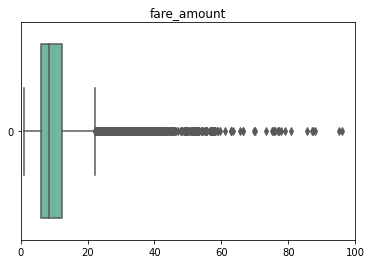

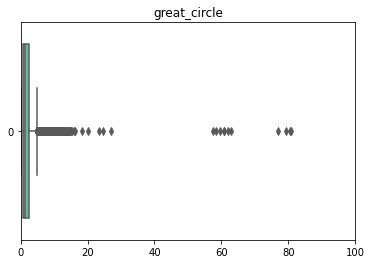

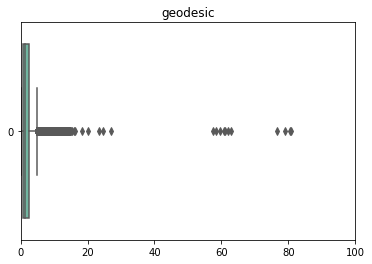

In [54]:
#################### Outlier Analysis #############################

### Checking Outliers using Boxplot Method

for i,col in enumerate(continous_variables):
    plt.figure(i)
    plt.title(col)
    plt.xlim(0,100)
    sns.boxplot(data=df[col], orient="h", palette="Set2")
    

In [55]:
#df1 = df.copy()

In [56]:
#Check for outliers using boxplots
for i in continous_variables:
    # Getting 75 and 25 percentile of variable "i"
    q75, q25 = np.percentile(df[i], [75,25])
    
    # Calculating Interquartile range
    iqr = q75 - q25
    
    # Calculating upper extream and lower extream
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    
    # Replacing all the outliers value to NA
    df.loc[df[i]< minimum,i] = np.nan
    df.loc[df[i]> maximum,i] = np.nan


# Impute missing values with KNN
df = pd.DataFrame(KNN(k = 3).fit_transform(df), columns = df.columns)
# Checking if there is any missing value
df.isnull().sum()

Imputing row 1/15266 with 0 missing, elapsed time: 158.199
Imputing row 101/15266 with 0 missing, elapsed time: 158.511
Imputing row 201/15266 with 0 missing, elapsed time: 158.543
Imputing row 301/15266 with 0 missing, elapsed time: 158.590
Imputing row 401/15266 with 0 missing, elapsed time: 158.746
Imputing row 501/15266 with 0 missing, elapsed time: 158.777
Imputing row 601/15266 with 0 missing, elapsed time: 158.808
Imputing row 701/15266 with 0 missing, elapsed time: 158.824
Imputing row 801/15266 with 0 missing, elapsed time: 158.871
Imputing row 901/15266 with 0 missing, elapsed time: 158.902
Imputing row 1001/15266 with 0 missing, elapsed time: 158.918
Imputing row 1101/15266 with 3 missing, elapsed time: 158.933
Imputing row 1201/15266 with 3 missing, elapsed time: 158.949
Imputing row 1301/15266 with 0 missing, elapsed time: 158.996
Imputing row 1401/15266 with 3 missing, elapsed time: 159.012
Imputing row 1501/15266 with 0 missing, elapsed time: 159.027
Imputing row 1601/15

Imputing row 13301/15266 with 0 missing, elapsed time: 160.137
Imputing row 13401/15266 with 0 missing, elapsed time: 160.153
Imputing row 13501/15266 with 0 missing, elapsed time: 160.153
Imputing row 13601/15266 with 0 missing, elapsed time: 160.153
Imputing row 13701/15266 with 0 missing, elapsed time: 160.153
Imputing row 13801/15266 with 0 missing, elapsed time: 160.168
Imputing row 13901/15266 with 0 missing, elapsed time: 160.168
Imputing row 14001/15266 with 0 missing, elapsed time: 160.168
Imputing row 14101/15266 with 0 missing, elapsed time: 160.184
Imputing row 14201/15266 with 0 missing, elapsed time: 160.184
Imputing row 14301/15266 with 0 missing, elapsed time: 160.184
Imputing row 14401/15266 with 0 missing, elapsed time: 160.199
Imputing row 14501/15266 with 0 missing, elapsed time: 160.199
Imputing row 14601/15266 with 3 missing, elapsed time: 160.199
Imputing row 14701/15266 with 0 missing, elapsed time: 160.199
Imputing row 14801/15266 with 2 missing, elapsed time: 

fare_amount            0
passenger_count_1.0    0
passenger_count_2.0    0
passenger_count_3.0    0
passenger_count_4.0    0
                      ..
seasons_spring         0
seasons_summer         0
week_weekend           0
great_circle           0
geodesic               0
Length: 62, dtype: int64

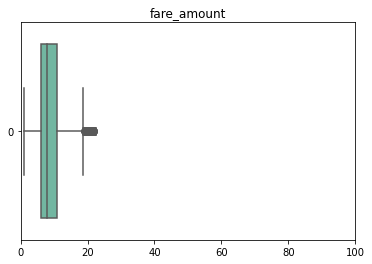

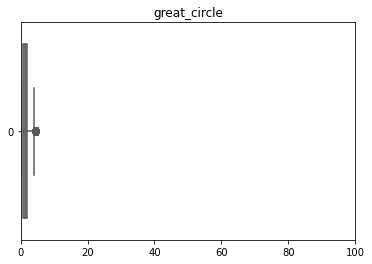

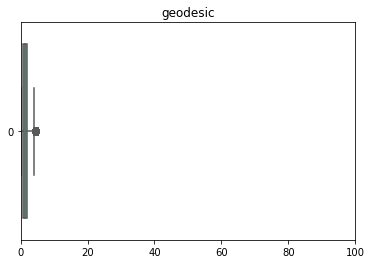

In [57]:
### Checking Outliers using Boxplot Method After updating

for i,col in enumerate(continous_variables):
    plt.figure(i)
    plt.title(col)
    plt.xlim(0,100)
    sns.boxplot(data=df[col], orient="h", palette="Set2")

# Feature Selection

In [58]:
# Create df from continous variables
df_corr = df.loc[:,continous_variables]

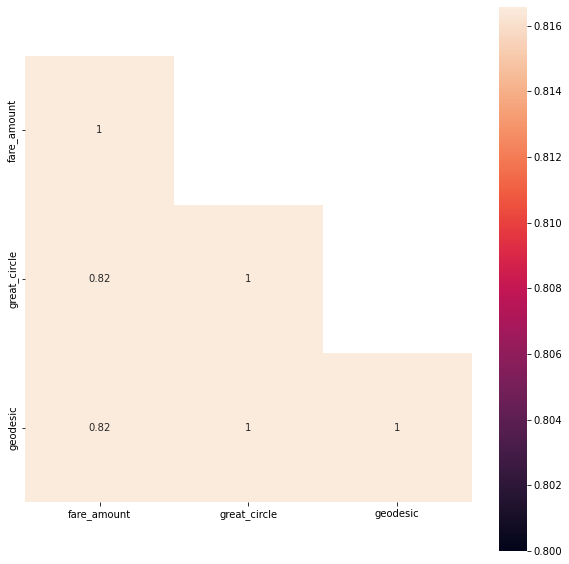

In [59]:
# Corelation graph for checking Multicollinearity for continous variables
f, ax = plt.subplots(figsize=(10, 10))

#Generate correlation matrix
corr = df_corr.corr()

#Plot heatmap using seaborn library
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
ax = sns.heatmap(corr, mask=mask, vmax=.8, square=True, annot=True, ax=ax)


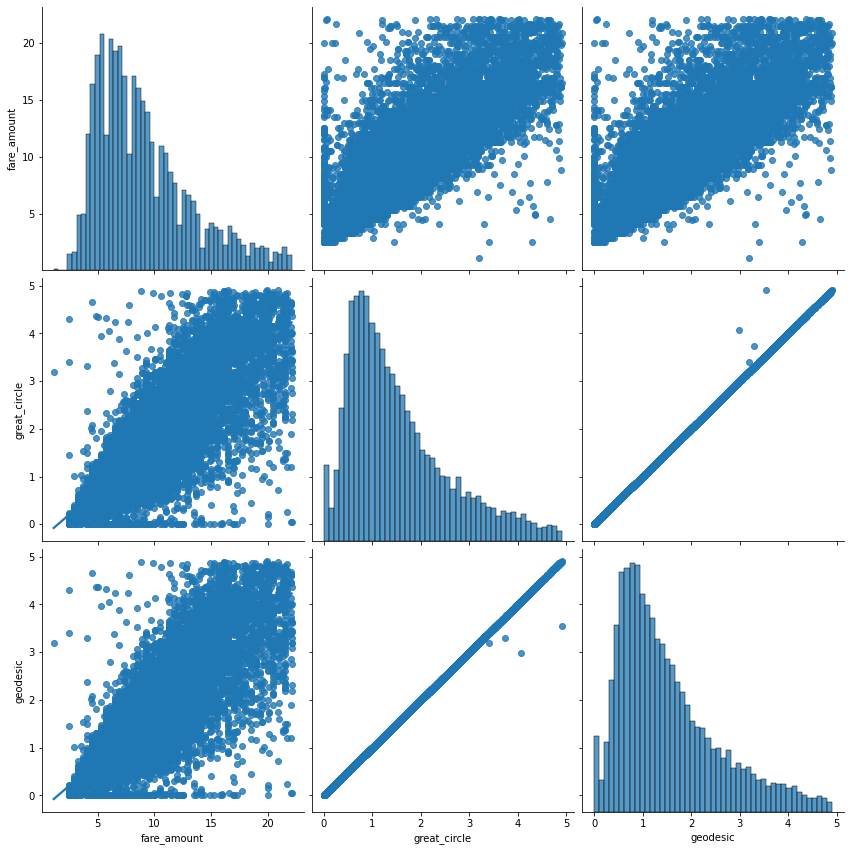

In [60]:
sns.pairplot(df_corr[continous_variables], height = 4, kind="reg")

In [61]:
### As Observed, great_circle and geodesic have high positively correlated values, hence one variable can be removed
df = df.drop('great_circle',axis=1)

# Updating the Continuous and Categorical Variables
continous_variables.remove('great_circle')

In [62]:
#loop for ANOVA test Since the target variable is continuous
for i in categorical_variables_train:
    f, p = stats.f_oneway(df[i], df["fare_amount"])
    print("P value for variable "+str(i)+" is "+str(p))

P value for variable passenger_count_1.0 is 0.0
P value for variable passenger_count_2.0 is 0.0
P value for variable passenger_count_3.0 is 0.0
P value for variable passenger_count_4.0 is 0.0
P value for variable passenger_count_5.0 is 0.0
P value for variable year_2009 is 0.0
P value for variable year_2010 is 0.0
P value for variable year_2011 is 0.0
P value for variable year_2012 is 0.0
P value for variable year_2013 is 0.0
P value for variable year_2014 is 0.0
P value for variable month_1 is 0.0
P value for variable month_2 is 0.0
P value for variable month_3 is 0.0
P value for variable month_4 is 0.0
P value for variable month_5 is 0.0
P value for variable month_6 is 0.0
P value for variable month_7 is 0.0
P value for variable month_8 is 0.0
P value for variable month_9 is 0.0
P value for variable month_10 is 0.0
P value for variable month_11 is 0.0
P value for variable day_of_week_0 is 0.0
P value for variable day_of_week_1 is 0.0
P value for variable day_of_week_2 is 0.0
P value 

In [63]:
# #loop for chi square values
# from scipy.stats import chi2_contingency

# for i in categorical_variables_train:
#     for j in categorical_variables_train:
#         if(i != j):
#             chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[i], df[j]))
#             if(p < 0.05):
#                 print(i,"and",j,"are dependent on each other with",p,'----Remove')
#             else:
#                 print(i,"and",j,"are independent on each other with",p,'----Keep')

In [64]:
#Make a copy of clean data
clean_data = df.copy()

# Feature Scaling

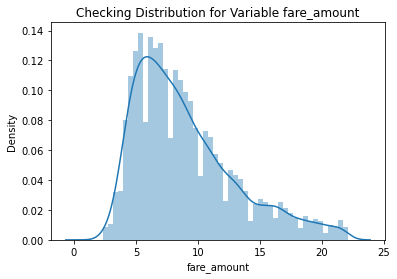

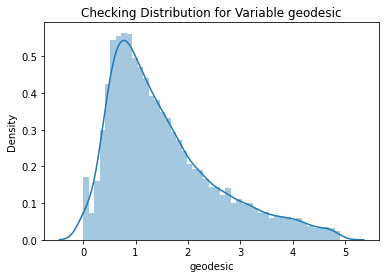

In [65]:
#Normality check
for i in continous_variables:
    sns.distplot(df[i],bins = 'auto')
    plt.title("Checking Distribution for Variable "+str(i))
    plt.ylabel("Density")
    plt.show()

In [66]:
#Normalization of continuous variables
df['geodesic'] = (df['geodesic'] - min(df['geodesic']))/(max(df['geodesic']) - min(df['geodesic']))
car_df_test['geodesic'] = (car_df_test['geodesic'] - min(car_df_test['geodesic']))/(max(car_df_test['geodesic']) - min(car_df_test['geodesic']))

## Splitting train into train and validation subsets
- X_train y_train--are train subset
- X_test y_test--are validation subset

In [67]:
X = df.drop('fare_amount',axis=1).values
y = df['fare_amount'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print(df.shape, X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(15266, 61) (11449, 60) (3817, 60) (11449,) (3817,)


In [68]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('####################### Training Data Score ######################')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('####################### Testing Data Score ######################')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))
    
    #Comparison Dataframe
    model_eval = pd.DataFrame({'predicted':y_pred, 'actual': y_test})
    print(model_eval.head())
    #Scatter plot of Actual vs Predicted
    ax = sns.lmplot(x="predicted", y="actual", data=model_eval)

## Multiple Linear Regression

In [69]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': False}
Best score is 0.665144897821143


R^2: 0.6687902317047233
Root Mean Squared Error: 2.3613711623808715
####################### Training Data Score ######################

r square   0.6675363726908706
Adjusted r square:0.6657847202814442
MAPE:20.218983154912046
MSE: 5.678920123303159
RMSE: 2.3830484936952416
RMSLE: 0.22648019589050133

####################### Testing Data Score ######################

r square   0.6687902317047233
Adjusted r square:0.6634993408373866
MAPE:20.13495596849379
MSE: 5.5760737665239875
RMSE: 2.3613711623808715
RMSLE: 0.22430349579269615
   predicted  actual
0  11.066406    10.9
1   5.742188     5.3
2   7.876953     7.3
3   7.029297     6.5
4   5.658203     5.0
                  Names  Coefficients
0           fare_amount -6.384859e-01
1   passenger_count_1.0 -6.118429e-01
2   passenger_count_2.0 -6.563651e-01
3   passenger_count_3.0 -4.494499e-01
4   passenger_count_4.0 -6.826236e-01
5   passenger_count_5.0 -2.693135e-01
6             year_2009 -1.394570e-01
7             year_2010 -2.541675e

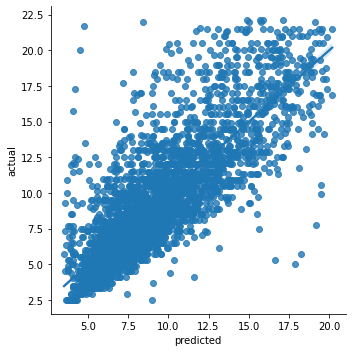

In [70]:
# Create the regressor: reg_all
reg_all = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
df_linear_coeff = pd.DataFrame(zip(df.columns, reg_all.coef_.tolist()), columns=['Names', 'Coefficients'])
print(df_linear_coeff)




In [71]:
from sklearn.model_selection import cross_val_score
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.56349909 -5.59722802 -5.45267398 -5.92053547 -5.96234121]
Average 5-Fold CV Score: -5.699255552513149


## Ridge Regression

In [72]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2')

# Fit it to the data
ridge_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 0.0020235896477251557, 'max_iter': 500, 'normalize': True}
Best score is 0.6652581554760395


[-6.13879992e-01 -5.55518715e-01 -5.56407758e-01 -3.67315965e-01
 -6.19609058e-01 -1.78203683e-01 -1.00981510e-01 -9.02461572e-02
 -1.24458267e-01 -6.68522454e-02 -4.65801383e-02 -1.46821559e-01
 -1.34108162e-01 -1.60734758e-02  4.42966120e-04 -1.29514142e-01
 -1.09218026e-01 -3.75262452e-02 -5.45294309e-02 -1.73381422e-02
 -6.75177947e-02  5.77930365e-03  6.17333300e-02 -7.65826435e-03
 -6.53812102e-02  5.86621348e-04 -2.72977121e-02 -8.61910557e-02
  1.72354902e-02 -1.69123695e-01 -9.88742213e-03 -9.44069958e-02
  1.82719609e-02 -3.88846358e-01  9.47859723e-02 -2.56852611e-02
  1.23447876e-01  8.68376091e-02 -9.55843565e-02  3.06440543e-02
  1.02154615e-01 -3.31324359e-02 -1.63795665e-01 -5.33329496e-02
 -4.41905091e-02  7.51462056e-02 -6.55751368e-02 -9.08290416e-02
  1.34097553e-01 -8.29083694e-02 -2.80552371e-01 -4.73099050e-02
  9.56766528e-03  2.15865546e-02  6.33177308e-02 -3.23840651e-02
 -6.05857734e-02 -8.50560215e-02  2.64111158e-02  1.58866176e+01]
####################### 

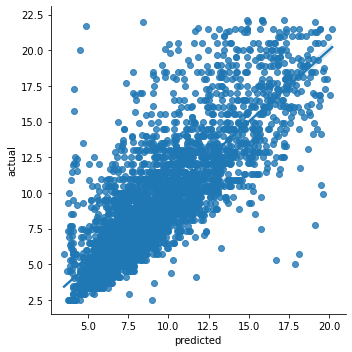

In [73]:
# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.0005428675439323859, normalize=True,max_iter = 500)

# Fit the regressor to the data
ridge.fit(X_train,y_train)

# Compute and print the coefficients
ridge_coef = ridge.coef_
print(ridge_coef)

test_scores(ridge)

lasso can be used feature selection

## Lasso Regression

In [74]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision lasso classifier: lasso
lasso = Lasso()

# Instantiate the gridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_dist, cv=5,scoring='r2')

# Fit it to the data
lasso_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision lasso Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

Tuned Decision lasso Parameters: {'alpha': 0.0004498432668969444, 'max_iter': 500, 'normalize': True}
Best score is 0.6660511161391163


[-6.64150492e-01 -6.27122242e-01 -6.20969293e-01 -4.46356383e-01
 -6.92912007e-01 -1.06696401e-01 -7.31112300e-03 -6.03443941e-02
 -8.84159378e-02  7.97760334e-03 -3.32445592e-02 -6.86848859e-02
 -1.21793952e-01 -5.34673637e-02  2.23297936e-06 -9.97192200e-02
 -2.68764249e-02  2.05071548e-05 -2.75160718e-02 -2.42707310e-04
  2.88526236e-02  2.93750936e-05  5.29404292e-02 -1.26488135e-04
 -6.36301391e-02  1.35462527e-04 -5.36723590e-03 -1.20751486e-01
  7.65637682e-02 -0.00000000e+00 -1.79602616e-02 -7.09702540e-02
 -0.00000000e+00 -3.24083779e-01  4.54354956e-02 -0.00000000e+00
  8.46777857e-02  1.25668665e-01 -4.15744224e-02  2.10765542e-02
  1.65242095e-01  2.74149620e-02 -9.99162758e-02 -0.00000000e+00
 -7.44006059e-03  1.04790791e-01  0.00000000e+00 -3.02161001e-02
  1.61470313e-01 -1.30330277e-01 -2.84571367e-01 -3.43213383e-02
  3.82886314e-02  8.00103996e-02  1.76526712e-01  4.39353014e-03
 -1.93230338e-02 -1.18366027e-01  3.64842081e-02  1.59102201e+01]
####################### 

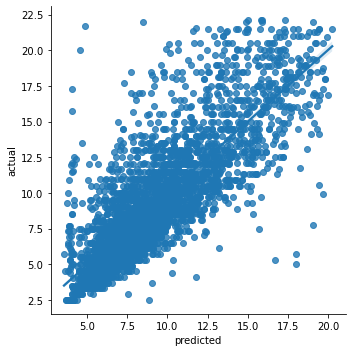

In [75]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.00021209508879201905, normalize=False,max_iter = 500)

# Fit the regressor to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

test_scores(lasso)

## Decision Tree Regression

In [76]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 4, 'min_samples_split': 2}
Best score is 0.6711736683985597


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.08378113e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.76462130e-04 6.56913655e-04
 0.00000000e+00 0.00000000e+00 3.54734256e-04 3.29191761e-04
 0.00000000e+00 3.52848088e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.98287341e-04 1.41457512e-03
 0.00000000e+00 5.78722592e-04 0.00000000e+00 0.00000000e+00
 5.98401366e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.84083246e-04
 7.26420803e-04 0.00000000e+00 1.01440286e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.42199874e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.09531650e-04 5.29770201e-04 6.23631152e-04
 4.64529846e-04 3.67705961e-04 0.00000000e+00 9.89569210e-01]
####################### Training Data Score ######################

r square   0.693

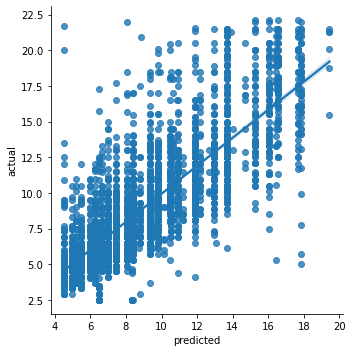

In [77]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=2)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Make predictions and cal error
test_scores(tree)

## Random Forest Regression

In [78]:
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}
Best score is 0.6759011803784765


[1.78575353e-03 8.06543188e-04 5.69125208e-04 3.50546249e-04
 7.57700075e-04 1.48381062e-03 1.34049097e-03 1.15184371e-03
 9.83817640e-04 1.04848875e-03 1.28997762e-03 1.00299434e-03
 5.05125824e-04 1.06023514e-03 8.71624821e-04 6.90907557e-04
 7.53122028e-04 6.60410775e-04 8.83177690e-04 9.00539633e-04
 5.13887661e-04 1.06775974e-03 1.36988083e-03 1.01548133e-03
 1.05762386e-03 1.27897415e-03 1.40277869e-03 1.99393680e-03
 6.70221069e-04 6.78080901e-04 1.89064509e-04 2.82876383e-04
 5.74806326e-04 4.93955958e-05 4.03810280e-04 4.42378398e-04
 9.48634153e-04 7.20248711e-04 4.75848547e-04 8.57054468e-04
 7.63078336e-04 6.50496344e-04 6.64039157e-04 7.43607906e-04
 4.95668035e-04 5.35931818e-04 7.51231014e-04 4.84026026e-04
 1.08873374e-03 6.46221422e-04 5.95393063e-04 1.30055762e-03
 9.07518972e-04 1.43245435e-03 1.38304182e-03 1.50039362e-03
 1.58433400e-03 1.32427527e-03 1.45054268e-03 9.46809477e-01]
####################### Training Data Score ######################

r square   0.738

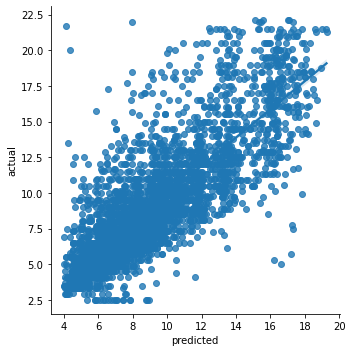

In [79]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=100, min_samples_split= 2, min_samples_leaf=4, \
                               max_features='auto', max_depth=9, bootstrap=True)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

test_scores(Forest)

In [80]:
from sklearn.model_selection import cross_val_score
# Create a random forest regression object: Forest
Forest = RandomForestRegressor(n_estimators=400, min_samples_split= 2, min_samples_leaf=4, \
                               max_features='auto', max_depth=12, bootstrap=True)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(Forest,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.51464187 -5.50315857 -5.52313109 -5.77820276 -5.80813268]
Average 5-Fold CV Score: -5.625453395106144


## Improving accuracy using XGBOOST
- Improve Accuracy a) Algorithm Tuning b) Ensembles

In [81]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [82]:
dtrain,dtest,data_dmatrix

(<xgboost.core.DMatrix at 0x232868f0be0>,
 <xgboost.core.DMatrix at 0x23284c00d90>)

In [83]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, \
                    early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

[11:43:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.561544,0.011442,8.562211,0.048557
1,7.819224,0.058598,7.821257,0.062035
2,7.220863,0.063109,7.223078,0.065964
3,6.675575,0.094375,6.676959,0.090145
4,6.161336,0.049625,6.162983,0.062025


In [84]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

49    2.436534
Name: test-rmse-mean, dtype: float64


####################### Training Data Score ######################

r square   0.831251488402075
Adjusted r square:0.8303624024610954
MAPE:14.973808402623934
MSE: 2.882448603617814
RMSE: 1.6977775483312925
RMSLE: 0.16596335949026964

####################### Testing Data Score ######################

r square   0.6459758263148447
Adjusted r square:0.6403204880770628
MAPE:21.056729755515033
MSE: 5.960165117597703
RMSE: 2.4413449403141914
RMSLE: 0.2333664396065485
   predicted  actual
0  12.463996    10.9
1   5.154791     5.3
2   6.922424     7.3
3   7.412126     6.5
4   5.610310     5.0


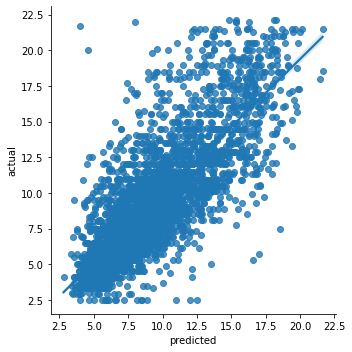

In [85]:
Xgb = XGBRegressor()
Xgb.fit(X_train,y_train)
# pred_xgb = model_xgb.predict(X_test)
test_scores(Xgb)

In [86]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

# Fit it to the data
xgb_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))


Tuned Xgboost Parameters: {'subsample': 0.7000000000000001, 'reg_alpha': 0.0029470517025518097, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.1, 'colsample_bynode': 0.7000000000000001, 'colsample_bylevel': 0.9000000000000001}
Best score is 0.6702948529718293


[0.01331371 0.00790716 0.01029696 0.01392816 0.01299997 0.0104322
 0.0112596  0.01293606 0.01134921 0.01539272 0.01386619 0.01398415
 0.01140983 0.01436057 0.01190361 0.01024576 0.01346429 0.01305547
 0.00997069 0.00882086 0.011356   0.01706624 0.0130642  0.00967068
 0.00983527 0.01307185 0.01125079 0.01842771 0.01715925 0.01396996
 0.01075262 0.01390921 0.02139916 0.0276706  0.00998244 0.01199233
 0.01697178 0.01206113 0.01221104 0.01415228 0.01314988 0.0178513
 0.01271001 0.00832141 0.01235841 0.0142411  0.01547115 0.01383345
 0.01617813 0.01230763 0.00943172 0.01796072 0.01815297 0.01629731
 0.01535075 0.01776762 0.01362287 0.01438768 0.01085158 0.2028826 ]
####################### Training Data Score ######################

r square   0.6884008866182836
Adjusted r square:0.686759163154734
MAPE:19.46283391062575
MSE: 5.3225265263123145
RMSE: 2.307060147961538
RMSLE: 0.21678814556888432

####################### Testing Data Score ######################

r square   0.6708495531678724
A

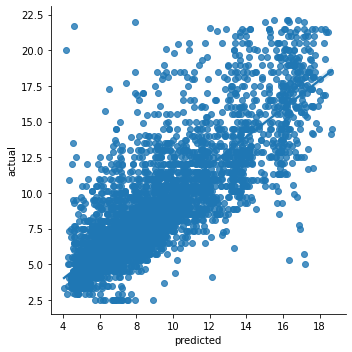

In [87]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, \
                   max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, \
                   colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X_train,y_train)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

test_scores(Xgb)

## Finalize model
- Create standalone model on entire training dataset
- Save model for later use

In [88]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def score(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_)))
    print('RMSLE:',rmsle(y_test,y_pred))
def scores(model):
    print('############################# Training Data Score ##############################')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X)
    score(y,y_pred)
    
    #Comparison Dataframe
    model_eval = pd.DataFrame({'predicted':y_pred, 'actual': y})
    print(model_eval.head())
    #Scatter plot of Actual vs Predicted
    ax = sns.lmplot(x="predicted", y="actual", data=model_eval)
    
    
    

In [89]:
car_df_test.columns

Index(['passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'year_2009', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'session_afternoon', 'session_evening', 'session_morning',
       'session_night_PM', 'seasons_fall', 'seasons_spring', 'seasons_summer',
       'week_weekend', 'great_circle', 'geodesic'],
      dtype='object')

In [90]:
car_df_train.columns

Index(['fare_amount', 'passenger_count_1.0', 'passenger_count_2.0',
       'passenger_count_3.0', 'passenger_count_4.0', 'passenger_count_5.0',
       'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'session_afternoon', 'session_evening', 'session_morning',
       'session_night_PM', 'seasons_fall', 'seasons_spring', 'seasons_summer',
       'week_weekend', 'great_circle', 'geodesic'],
      dtype='object')

In [92]:
a=pd.read_csv("D:\\projects\\Self Project\\New York City Taxi Fare Prediction\\dataset\\test.csv")
test_pickup_datetime=a['pickup_datetime']

In [93]:
car_df_test_1 = car_df_test.copy()

In [94]:
car_df_test_1 = car_df_test_1.rename(columns = {"passenger_count_1": "passenger_count_1.0",
                    "passenger_count_2": "passenger_count_2.0",
                    "passenger_count_3": "passenger_count_3.0",
                    "passenger_count_4": "passenger_count_4.0",
                    "passenger_count_5": "passenger_count_5.0"
                    }) 

In [95]:
car_df_test_1 = car_df_test_1.drop('great_circle', axis=1)

[0.01222183 0.0128816  0.01372618 0.01305416 0.01371601 0.01495692
 0.00804696 0.01278265 0.01107002 0.01209876 0.01597841 0.01135675
 0.01160799 0.01633148 0.00954226 0.01611836 0.01356236 0.01514364
 0.00904228 0.01165477 0.00948061 0.01401629 0.01435943 0.01244492
 0.01322275 0.01693969 0.00921664 0.01223837 0.01433301 0.01075592
 0.01339457 0.01247553 0.01644348 0.01044459 0.01150028 0.01039276
 0.01121958 0.01516494 0.01018094 0.01373227 0.01443943 0.01038799
 0.01242126 0.01200523 0.01465153 0.01592312 0.01475024 0.01218365
 0.01281803 0.01274815 0.01322853 0.01529829 0.01296318 0.01656729
 0.01439566 0.01613758 0.01112247 0.01628417 0.01486884 0.22995532]
############################# Training Data Score ##############################

r square   0.6858939188052144
Adjusted r square:0.6846544341046761
MAPE:19.57988869056554
MSE: 5.346216729842913
RMSE: 2.312188731449687
RMSLE: 0.22430349579269615
   predicted  actual
0   5.656184     4.5
1  16.353056    16.9
2   6.572879     5.7

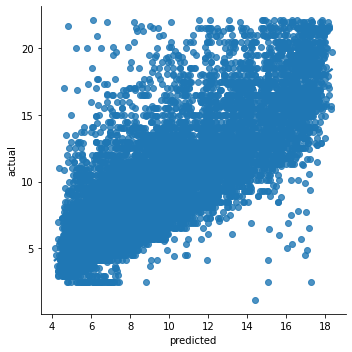

In [96]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X,y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

scores(Xgb)

# Predictions
pred = Xgb.predict(car_df_test_1.values)
pred_results_wrt_date = pd.DataFrame({"pickup_datetime":test_pickup_datetime,"fare_amount" : pred})
pred_results_wrt_date.to_csv("predictions_xgboost.csv",index=False)

In [97]:
pred_results_wrt_date

,pickup_datetime,fare_amount
0,2015-01-27 13:08:24 UTC,5.891248
1,2015-01-27 13:08:24 UTC,5.779104
2,2011-10-08 11:53:44 UTC,6.103760
3,2012-12-01 21:12:12 UTC,4.968854
4,2012-12-01 21:12:12 UTC,4.567230
...,...,...
9909,2015-05-10 12:37:51 UTC,5.725497
9910,2015-01-12 17:05:51 UTC,5.566887
9911,2015-04-19 20:44:15 UTC,7.124854
9912,2015-01-31 01:05:19 UTC,4.982300


In [98]:
# Save the model as a pickle in a file 
joblib.dump(Xgb, 'cab_fare_xgboost_model.pkl') 
  
# # Load the model from the file 
# Xgb_from_joblib = joblib.load('cab_fare_xgboost_model.pkl')  

['cab_fare_xgboost_model.pkl']